In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# HSMMの性能比較の数値実験

In [2]:
import sys
sys.path.append("../lib")

In [3]:
import math

from IPython.core.display import display, Markdown, Latex
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, cauchy, laplace, gumbel_r, gamma, skewnorm, pareto, multivariate_normal
from typing import Callable
from sklearn.mixture import BayesianGaussianMixture

from learning import HyperbolicSecantMixtureVB, GaussianMixtureModelVB
from util import GaussianMixtureModel, HyperbolicSecantMixtureModel, StudentMixtureModel, LaplaceMixtureModel, GumbelMixtureModel

# 問題設定

## 真の分布の設定
+ データ生成分布は変更しますが、混合比, 中心, scaleは同じものを流用

In [4]:
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[0.1, 0.1], [0.5, 0.5], [1, 1]])
true_b = np.array([[2, 4], [-4, -2], [0, 0]])
true_param = dict()
true_param["ratio"] = true_ratio
true_param["mean"] = true_b
true_param["precision"] = true_s
true_param["scale"] = np.array([np.diag(1/np.sqrt(true_s[k,:])) for k in range(len(true_ratio))])
K0 = len(true_ratio)
M = true_b.shape[1]

## Learning setting:

In [5]:
### 学習データの数
n = 400

### テストデータの数
N = 10000

### データの出方の個数
ndataset = 50

### 事前分布のハイパーパラメータ
pri_params = {
    "pri_alpha": 0.1,
    "pri_beta": 0.001,
    "pri_gamma": M+2,
    "pri_delta": 1
}

### データ生成の回数
data_seed_start = 201907
data_seeds = np.arange(start = data_seed_start, stop = data_seed_start + ndataset, step = 1)

### 学習モデルの初期値の乱数 -> データseedにoffsetを加えたものを使う
learning_num = 10
learning_seed_offset = 100

### 繰り返しアルゴリズムの繰り返し回数
learning_iteration = 1000

### 学習モデルのコンポーネントの数
K = np.array([3, 5])

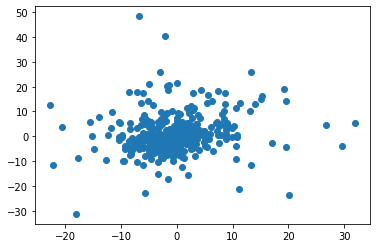

In [17]:
test = HyperbolicSecantMixtureModel.rvs(true_ratio, true_b, true_s, size=n)[0]
plt.scatter(test[:,0], test[:,1])
plt.show()

# 性能評価
+ 1連の流れ
    1. データ生成する
    1. 学習を行う
    1. 精度評価を行う
    1. 1に戻って再度計算

# コンポーネントの分布が正規分布の場合

In [6]:
gerror_gmm = np.zeros(len(data_seeds))
cklerror_gmm = np.zeros(len(data_seeds))
c01error_gmm = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = GaussianMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = GaussianMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "diag")
    gmm_diag_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    posterior_true_logprob = GaussianMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -GaussianMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

In [7]:
print(f"""
gerror_gmm: {gerror_gmm.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm: {cklerror_gmm.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm: {c01error_gmm.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm: 0.023986380276039432,
gerror_hsmm: 0.04337281269765235,
cklerror_gmm: 0.014579801789498532,
cklerror_hsmm: 0.0709953482507086,
c01error_gmm: 0.922,
c01error_hsmm: 0.9018



# コンポーネントの分布が双曲線正割分布の場合

In [19]:
gerror_gmm = np.zeros(len(data_seeds))
cklerror_gmm = np.zeros(len(data_seeds))
c01error_gmm = np.zeros(len(data_seeds))
norm_energy_gmm = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))
norm_energy_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = HyperbolicSecantMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = HyperbolicSecantMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, method = "diag", 
                                     restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    gmm_diag_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = HyperbolicSecantMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -HyperbolicSecantMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)
    

KeyboardInterrupt: 

In [20]:
print(f"""
gerror_gmm: {gerror_gmm.mean()}, 
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm: {cklerror_gmm.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm: {c01error_gmm.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm: 0.06892306319813438, 
gerror_hsmm: 0.025866372869894683,
cklerror_gmm: 23.196797851652317,
cklerror_hsmm: 1.9863084679143197,
c01error_gmm: 0.6836,
c01error_hsmm: 0.7382500000000001



# コンポーネントの分布がt分布の場合

In [10]:
gerror_gmm = np.zeros(len(data_seeds))
cklerror_gmm = np.zeros(len(data_seeds))
c01error_gmm = np.zeros(len(data_seeds))
# norm_energy_gmm = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))
# norm_energy_hsmm = np.zeros(len(data_seeds))

true_df = 3
for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = StudentMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed, df = true_df)
    (test_X, test_label, test_label_arg) = StudentMixtureModel.rvs(true_ratio, true_b, true_s, size = N, df = true_df)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, method = "diag", 
                                     restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    gmm_diag_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = StudentMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s, df = true_df)
    cklerror_gmm[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)    
    
    c01error_gmm[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -StudentMixtureModel.logpdf(test_X, true_ratio, true_b, true_s, df = true_df)
    gerror_gmm[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)
    

In [11]:
print(f"""
gerror_gmm: {gerror_gmm.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm: {cklerror_gmm.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm: {c01error_gmm.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm: 0.19620487509839105,
gerror_hsmm: 0.03907924619254339,
cklerror_gmm: 3.719392759549088,
cklerror_hsmm: 1.5787704723958722,
c01error_gmm: 0.7676500000000002,
c01error_hsmm: 0.8492999999999999



# コンポーネントの分布がラプラス分布の場合

In [12]:
gerror_gmm = np.zeros(len(data_seeds))
cklerror_gmm = np.zeros(len(data_seeds))
c01error_gmm = np.zeros(len(data_seeds))
# norm_energy_gmm = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))
# norm_energy_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = LaplaceMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = LaplaceMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, method = "diag", 
                                     restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    gmm_diag_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = LaplaceMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)   
    
    c01error_gmm[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -LaplaceMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)
    

In [13]:
print(f"""
gerror_gmm: {gerror_gmm.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm: {cklerror_gmm.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm: {c01error_gmm.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm: 0.10545562558925133,
gerror_hsmm: 0.03266588382364332,
cklerror_gmm: 1.7618997379222217,
cklerror_hsmm: 1.4220849553036825,
c01error_gmm: 0.7943000000000001,
c01error_hsmm: 0.8590000000000001



# コンポーネントの分布がガンベル分布の場合

In [10]:
gerror_gmm = np.zeros(len(data_seeds))
cklerror_gmm = np.zeros(len(data_seeds))
c01error_gmm = np.zeros(len(data_seeds))
# norm_energy_gmm = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))
# norm_energy_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = GumbelMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = GumbelMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, method = "diag", 
                                     restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    gmm_diag_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = GumbelMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)   
    
    c01error_gmm[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -GumbelMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)
    

In [11]:
print(f"""
gerror_gmm: {gerror_gmm.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm: {cklerror_gmm.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm: {c01error_gmm.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm: 0.22086168027272243,
gerror_hsmm: 0.514092263661064,
cklerror_gmm: 0.05694911380538277,
cklerror_hsmm: 0.03389905365024883,
c01error_gmm: 0.9869,
c01error_hsmm: 0.9871500000000001

